# VLB Nonlocal — Shear Banding PDE

**Vernerey-Long-Brighenti (VLB) nonlocal model with tensor diffusion**

## Learning Objectives

- Understand nonlocal VLB with tensor diffusion and shear banding
- Simulate spatially-resolved shear flow across a gap
- Analyze cooperativity length and band width
- Visualize spatial profiles (shear rate, velocity, distribution tensor)
- Compare Bell breakage (S-shaped flow curve) vs constant breakage

## Prerequisites

- Familiarity with VLBLocal model (see `examples/vlb/01_vlb_flow_curve.ipynb`)
- Basic understanding of shear banding in complex fluids

## Estimated Runtime

- ~3-5 min (PDE integration with 51 spatial points)

## 1. Setup

In [1]:
# Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import VLBNonlocal

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)  # JAX/equinox upstream deprecation churn — not actionable in user notebooks
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]


## 2. Theory: Nonlocal VLB PDE

The nonlocal VLB model extends the local framework by solving a **1D PDE** across the gap of a Couette cell:

$$\frac{\partial \boldsymbol{\mu}}{\partial t} = k_d(\mathbf{I} - \boldsymbol{\mu}) + \mathbf{L} \cdot \boldsymbol{\mu} + \boldsymbol{\mu} \cdot \mathbf{L}^T + D_\mu \nabla^2 \boldsymbol{\mu}$$

where $D_\mu$ is the **distribution tensor diffusivity** (m²/s), a material constant that introduces spatial coupling.

**Shear Banding:**
- Occurs when the **Bell breakage rate** creates a non-monotonic constitutive curve (S-shaped $\sigma$ vs $\dot{\gamma}$)
- The diffusion term regularizes the banding interface and sets its width

**Cooperativity Length:**
$$\xi = \sqrt{\frac{D_\mu}{k_{d,0}}}$$

This is the characteristic length scale over which the distribution tensor varies, and it sets the width of the shear band interface.

**Boundary Conditions:**
- Neumann (zero flux) at both walls: $\partial \boldsymbol{\mu}/\partial y = 0$ at $y=0, H$

## 3. Model Setup with Bell Breakage

In [3]:
# Create nonlocal model with Bell breakage (enables shear banding)
model = VLBNonlocal(breakage="bell", n_points=51, gap_width=1e-3)

# Set parameters
model.parameters.set_value("G0", 1000.0)     # Elastic modulus (Pa)
model.parameters.set_value("k_d_0", 1.0)     # Base dissociation rate (1/s)
model.parameters.set_value("eta_s", 0.0)     # Solvent viscosity (Pa·s)
model.parameters.set_value("nu", 5.0)        # Bell activation volume (dimensionless)
model.parameters.set_value("D_mu", 1e-6)     # Tensor diffusivity (m²/s)

# Compute cooperativity length
xi = model.get_cooperativity_length()
print(f"Model parameters:")
print(f"  G₀     = {model.G0} Pa")
print(f"  k_d_0  = {model.k_d_0} 1/s")
print(f"  ν      = {model.parameters.get_value('nu')}")
print(f"  D_μ    = {model.parameters.get_value('D_mu'):.2e} m²/s")
print(f"  Gap    = {model.gap_width*1e3:.2f} mm")
print(f"  Points = {model.n_points}")
print(f"\nCooperativity length: ξ = {xi*1e6:.1f} μm")
print(f"Ratio ξ/H = {xi/model.gap_width:.3f}")

Model parameters:
  G₀     = 1000.0 Pa
  k_d_0  = 1.0 1/s
  ν      = 5.0
  D_μ    = 1.00e-06 m²/s
  Gap    = 1.00 mm
  Points = 51

Cooperativity length: ξ = 1000.0 μm
Ratio ξ/H = 1.000


## 4. Steady Shear Simulation

We simulate the approach to steady state under an imposed average shear rate. A small spatial perturbation is added to the initial condition to seed banding instability.

In [4]:
import time

gamma_dot_avg = 2.0  # Average shear rate (1/s)
t_end = 100.0        # Simulation time (s)
dt = 2.0             # Output time step (s)
perturbation = 0.05  # Initial spatial noise amplitude

print(f"Simulating steady shear with γ̇_avg = {gamma_dot_avg} 1/s...")
t0 = time.time()
result = model.simulate_steady_shear(
    gamma_dot_avg=gamma_dot_avg,
    t_end=t_end,
    dt=dt,
    perturbation=perturbation
)
t_elapsed = time.time() - t0
print(f"Simulation completed in {t_elapsed:.1f} s")
print(f"Time points: {len(result['t'])}")
print(f"Final time: {result['t'][-1]:.1f} s")

Simulating steady shear with γ̇_avg = 2.0 1/s...


Simulation completed in 5.3 s
Time points: 51
Final time: 100.0 s


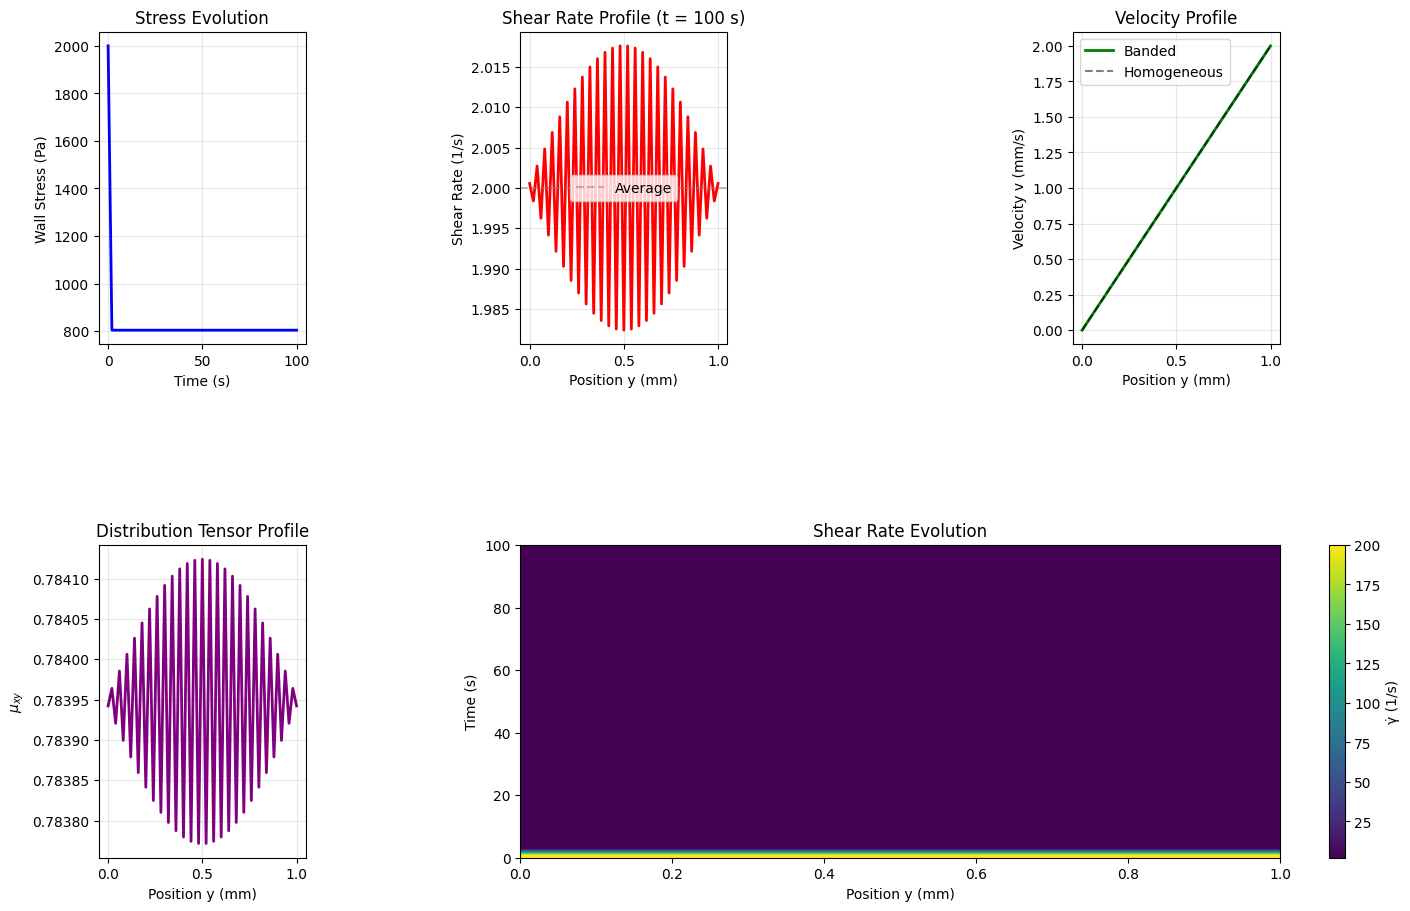

In [5]:
# Plot time evolution and spatial profiles
fig = plt.figure(figsize=(14, 9), constrained_layout=True)
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Stress evolution
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(result['t'], result['stress'], 'b-', lw=2)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Wall Stress (Pa)')
ax1.set_title('Stress Evolution')
ax1.grid(True, alpha=0.3)

# Final shear rate profile
ax2 = fig.add_subplot(gs[0, 1])
y_mm = result['y'] * 1e3  # Convert to mm
ax2.plot(y_mm, result['gamma_dot'][-1], 'r-', lw=2)
ax2.axhline(gamma_dot_avg, color='gray', linestyle='--', alpha=0.5, label='Average')
ax2.set_xlabel('Position y (mm)')
ax2.set_ylabel('Shear Rate (1/s)')
ax2.set_title(f'Shear Rate Profile (t = {result["t"][-1]:.0f} s)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Velocity profile
ax3 = fig.add_subplot(gs[0, 2])
v = model.get_velocity_profile(result)
v_mm_s = v * 1e3  # Convert to mm/s
# Linear (homogeneous) reference
v_linear = gamma_dot_avg * result['y'] * 1e3
ax3.plot(y_mm, v_mm_s, 'g-', lw=2, label='Banded')
ax3.plot(y_mm, v_linear, 'k--', lw=1.5, alpha=0.5, label='Homogeneous')
ax3.set_xlabel('Position y (mm)')
ax3.set_ylabel('Velocity v (mm/s)')
ax3.set_title('Velocity Profile')
ax3.legend()
ax3.grid(True, alpha=0.3)

# mu_xy profile
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(y_mm, result['mu_xy'][-1], 'purple', lw=2)
ax4.set_xlabel('Position y (mm)')
ax4.set_ylabel(r'$\mu_{xy}$')
ax4.set_title('Distribution Tensor Profile')
ax4.grid(True, alpha=0.3)

# Shear rate evolution (colormap)
ax5 = fig.add_subplot(gs[1, 1:])
extent = [0, result['y'][-1]*1e3, result['t'][0], result['t'][-1]]
im = ax5.imshow(result['gamma_dot'], aspect='auto', origin='lower', 
                extent=extent, cmap='viridis', interpolation='bilinear')
ax5.set_xlabel('Position y (mm)')
ax5.set_ylabel('Time (s)')
ax5.set_title('Shear Rate Evolution')
cbar = plt.colorbar(im, ax=ax5, label='γ̇ (1/s)')

display(fig)
plt.close(fig)

## 5. Banding Detection

We quantify shear banding by analyzing the spatial variation in the steady-state shear rate profile.

Banding Analysis:
  Is banding:        False
  Relative variation: 0.006 (threshold: 0.1)
  Band contrast:     1.02
  Band width:        440 μm (44.0% of gap)
  Band location:     0.500 mm


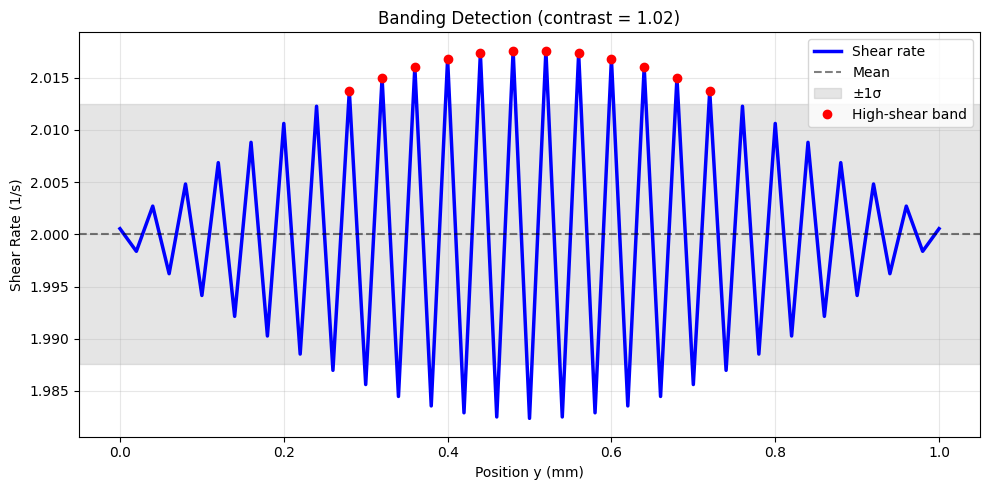

In [6]:
banding = model.detect_banding(result, threshold=0.1)

print("Banding Analysis:")
print(f"  Is banding:        {banding['is_banding']}")
print(f"  Relative variation: {banding['relative_variation']:.3f} (threshold: 0.1)")
print(f"  Band contrast:     {banding['band_contrast']:.2f}")
print(f"  Band width:        {banding['band_width']*1e6:.0f} μm ({banding['band_width_fraction']:.1%} of gap)")
print(f"  Band location:     {banding['band_location']*1e3:.3f} mm")

# Visualize banding region
fig, ax = plt.subplots(figsize=(10, 5))
gamma_dot_profile = banding['gamma_dot_profile']
mean_gd = np.mean(gamma_dot_profile)
std_gd = np.std(gamma_dot_profile)

ax.plot(y_mm, gamma_dot_profile, 'b-', lw=2.5, label='Shear rate')
ax.axhline(mean_gd, color='k', linestyle='--', alpha=0.5, label='Mean')
ax.axhspan(mean_gd - std_gd, mean_gd + std_gd, alpha=0.2, color='gray', label='±1σ')

# Highlight high-shear band
high_shear_mask = gamma_dot_profile > mean_gd + std_gd
if np.any(high_shear_mask):
    band_indices = np.where(high_shear_mask)[0]
    y_band = result['y'][band_indices] * 1e3
    gd_band = gamma_dot_profile[band_indices]
    ax.plot(y_band, gd_band, 'ro', markersize=6, label='High-shear band')

ax.set_xlabel('Position y (mm)')
ax.set_ylabel('Shear Rate (1/s)')
ax.set_title(f'Banding Detection (contrast = {banding["band_contrast"]:.2f})')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Homogeneous Test with Constant Breakage

For comparison, we run the same simulation with **constant breakage** (no Bell force dependence). This should give a **uniform shear rate profile** (no banding).

In [7]:
# Create model with constant breakage
model_const = VLBNonlocal(breakage="constant", n_points=51, gap_width=1e-3)

# Same parameters (except no Bell nu)
model_const.parameters.set_value("G0", 1000.0)
model_const.parameters.set_value("k_d_0", 1.0)
model_const.parameters.set_value("eta_s", 0.0)
model_const.parameters.set_value("D_mu", 1e-6)

print("Simulating with constant breakage (no banding expected)...")
t0 = time.time()
result_const = model_const.simulate_steady_shear(
    gamma_dot_avg=1.0,
    t_end=50.0,
    dt=5.0,
    perturbation=0.0  # No perturbation needed
)
t_elapsed = time.time() - t0
print(f"Simulation completed in {t_elapsed:.1f} s")

Simulating with constant breakage (no banding expected)...


Simulation completed in 0.6 s


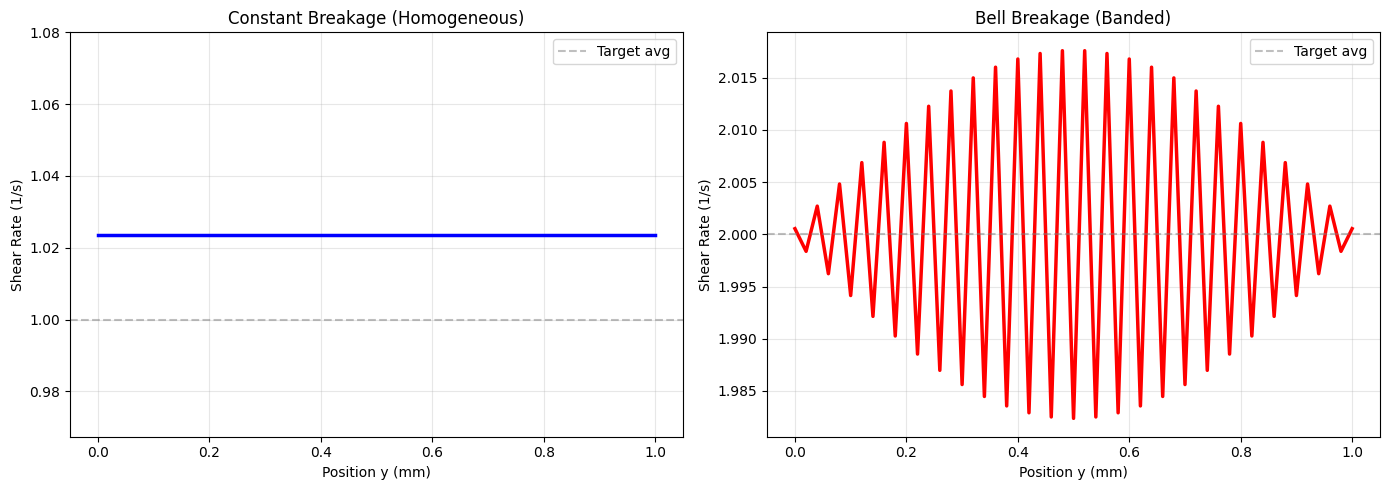


Constant breakage:
  Relative variation: 0.0000
  Band contrast:      1.000

Bell breakage:
  Relative variation: 0.0062
  Band contrast:      1.018


In [8]:
# Compare profiles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Constant breakage (homogeneous)
y_mm_const = result_const['y'] * 1e3
ax1.plot(y_mm_const, result_const['gamma_dot'][-1], 'b-', lw=2.5)
ax1.axhline(1.0, color='gray', linestyle='--', alpha=0.5, label='Target avg')
ax1.set_xlabel('Position y (mm)')
ax1.set_ylabel('Shear Rate (1/s)')
ax1.set_title('Constant Breakage (Homogeneous)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bell breakage (banded)
ax2.plot(y_mm, result['gamma_dot'][-1], 'r-', lw=2.5)
ax2.axhline(gamma_dot_avg, color='gray', linestyle='--', alpha=0.5, label='Target avg')
ax2.set_xlabel('Position y (mm)')
ax2.set_ylabel('Shear Rate (1/s)')
ax2.set_title('Bell Breakage (Banded)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

# Quantify uniformity
banding_const = model_const.detect_banding(result_const, threshold=0.1)
print(f"\nConstant breakage:")
print(f"  Relative variation: {banding_const['relative_variation']:.4f}")
print(f"  Band contrast:      {banding_const['band_contrast']:.3f}")
print(f"\nBell breakage:")
print(f"  Relative variation: {banding['relative_variation']:.4f}")
print(f"  Band contrast:      {banding['band_contrast']:.3f}")

## 7. Spatial Profile Visualization

We use the built-in plotting method to visualize all key spatial fields.

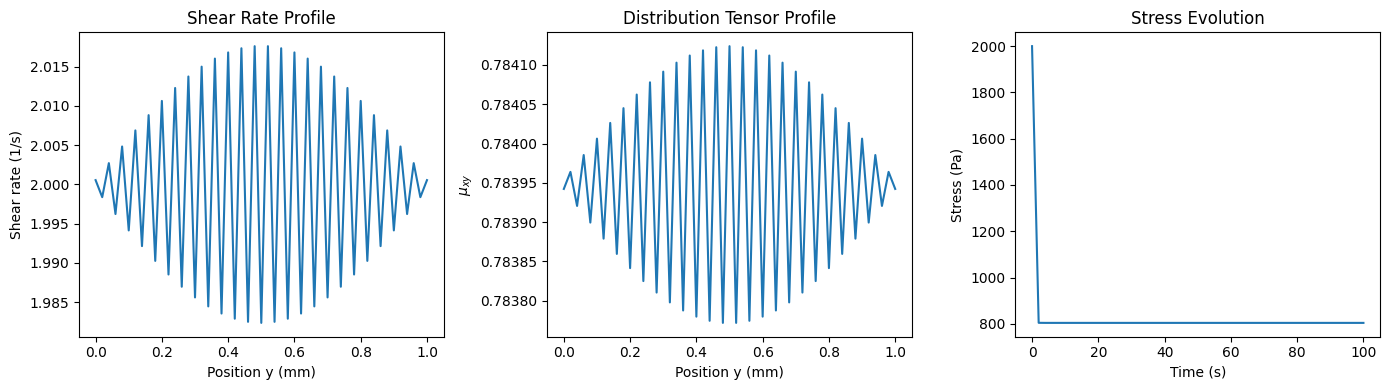

In [9]:
# Use built-in plot method
fig = model.plot_profiles(result)
display(fig)
plt.close(fig)

## 8. Parameter Sensitivity: Cooperativity Length

The cooperativity length $\xi = \sqrt{D_\mu/k_{d,0}}$ controls the band width. Let's explore its effect.

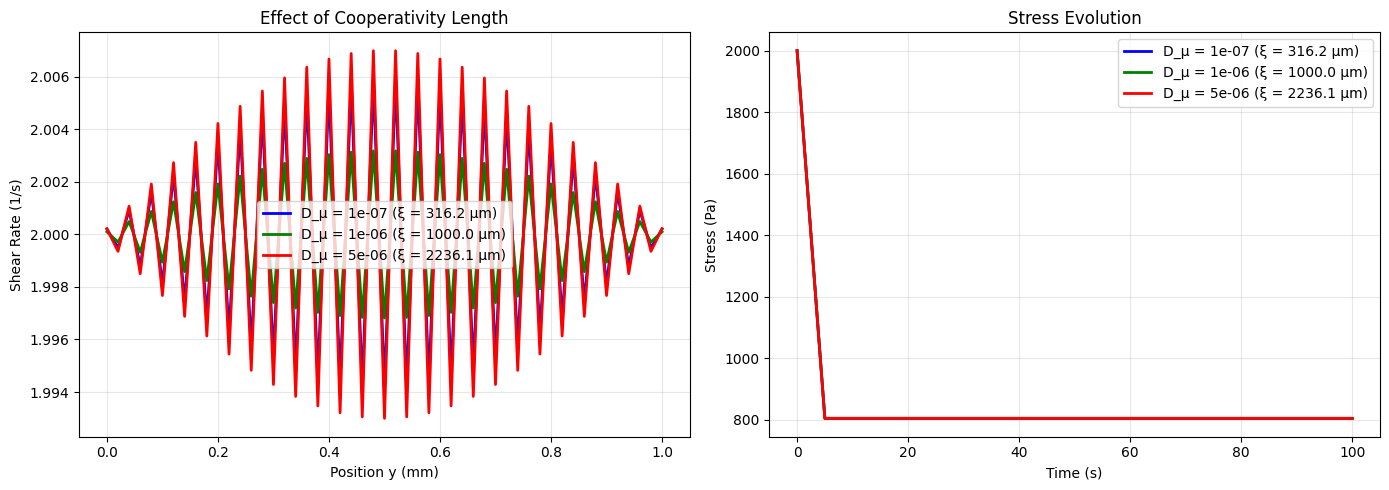

Observation: Larger D_μ (larger ξ) → wider interface, smoother gradients


In [10]:
# Test different D_mu values
D_mu_values = [1e-7, 1e-6, 5e-6]
colors = ['blue', 'green', 'red']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for D_mu, color in zip(D_mu_values, colors):
    model_sens = VLBNonlocal(breakage="bell", n_points=51, gap_width=1e-3)
    model_sens.parameters.set_value("G0", 1000.0)
    model_sens.parameters.set_value("k_d_0", 1.0)
    model_sens.parameters.set_value("eta_s", 0.0)
    model_sens.parameters.set_value("nu", 5.0)
    model_sens.parameters.set_value("D_mu", D_mu)
    
    xi_sens = model_sens.get_cooperativity_length()
    
    result_sens = model_sens.simulate_steady_shear(
        gamma_dot_avg=2.0, t_end=100.0, dt=5.0, perturbation=0.05
    )
    
    y_mm_sens = result_sens['y'] * 1e3
    label = f"D_μ = {D_mu:.0e} (ξ = {xi_sens*1e6:.1f} μm)"
    
    ax1.plot(y_mm_sens, result_sens['gamma_dot'][-1], 
             color=color, lw=2, label=label)
    ax2.plot(result_sens['t'], result_sens['stress'], 
             color=color, lw=2, label=label)

ax1.set_xlabel('Position y (mm)')
ax1.set_ylabel('Shear Rate (1/s)')
ax1.set_title('Effect of Cooperativity Length')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Stress (Pa)')
ax2.set_title('Stress Evolution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("Observation: Larger D_μ (larger ξ) → wider interface, smoother gradients")

## 9. Save Results

In [11]:
import json
import os

output_dir = os.path.join("..", "outputs", "vlb", "nonlocal")
os.makedirs(output_dir, exist_ok=True)

# Save parameters
params = {
    "G0": float(model.G0),
    "k_d_0": float(model.k_d_0),
    "nu": float(model.parameters.get_value("nu")),
    "D_mu": float(model.parameters.get_value("D_mu")),
    "gap_width": float(model.gap_width),
    "n_points": int(model.n_points),
    "cooperativity_length": float(xi),
}

with open(os.path.join(output_dir, "params.json"), "w") as f:
    json.dump(params, f, indent=2)

# Save banding results
banding_output = {
    "is_banding": bool(banding["is_banding"]),
    "relative_variation": float(banding["relative_variation"]),
    "band_contrast": float(banding["band_contrast"]),
    "band_width_um": float(banding["band_width"] * 1e6),
    "band_location_mm": float(banding["band_location"] * 1e3),
}

with open(os.path.join(output_dir, "banding_analysis.json"), "w") as f:
    json.dump(banding_output, f, indent=2)

print(f"Results saved to {output_dir}/")

Results saved to ../outputs/vlb/nonlocal/


## Key Takeaways

1. **Nonlocal VLB captures shear banding** — Bell breakage creates S-shaped flow curve that triggers spatial inhomogeneity
2. **Cooperativity length ξ sets band width** — Larger D_μ (or smaller k_d_0) → wider interface
3. **Constant breakage gives homogeneous flow** — No banding instability without force-dependent kinetics
4. **Velocity profile deviates from linear** — Direct signature of heterogeneous flow
5. **Band contrast quantifies banding** — Ratio of max/min shear rate across gap

## Next Steps

- **VLBLocal extensions**: Explore force-dependent breakage (Bell model) in 0D
- **VLBMultiNetwork**: Multi-mode distributions for complex relaxation spectra
- **Experimental comparison**: Fit velocity profiles from particle imaging velocimetry (PIV)